# Using Neural Networks to Classify Twitter (X) Data

Link to GitHub Repository: https://github.com/CJTAYL/NLP_Disaster_Tweet

Natural language processing (NLP) is an offshoot of computer science and linguistics that is often utilized by data scientists. Its primary task is to help humans review and interpret documents efficiently, which often involves one or more of subtasks, like speech recognition, natural-language generation, and natural-language understanding. A common language-understanding task is sentiment analysis, where text is reviewed and classified according to the author’s emotional tone.

Sentiment analysis is a useful tool for many types of organizations. For instance, a business may use sentiment analysis to examine customer reviews, or a news organization may use sentiment analysis to filter comments of a news story for hate speech. In fact, the text data used in sentiment analyses  can come from a variety of sources, like emails, books, academic papers, and social media.

Social media data is particularly valuable for news agencies due to the frequent user engagement with current events. One social media service that is conducive to sharing real time updates about current events is Twitter (or X) due to its structure focused on text and images.

Sentiment analyses can be conducted with several different machine learning models, including Artificial Neural Networks (ANNs). The basic structure of an ANN is an input layer, one or more hidden layers, and an output layer with nodes to connect the layers. Broadly, ANNs fall into two categories: single layer and multi-layer.

The purpose of this project is to demonstrate how ANNs can be used for sentiment analysis on social media data. Specifically, a simple artificial neural network was developed to identify posts from X as either posts about disasters (1) or posts not about disasters (0).

# Libraries and Modules Used

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import matplotlib.pyplot as plt # visualizations
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualizations

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load and Explore Data

In [57]:
train_df = pd.read_csv("/content/drive/MyDrive/IntroDeepLearning/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/IntroDeepLearning/test.csv")

In [58]:
print(f"Number of Rows in Training DataFrame: {train_df.shape[0]}")
print(f"Number of Columns in Training DataFrame: {train_df.shape[1]}")
print("---------------")
print(f"Number of Rows in Testing DataFrame: {test_df.shape[0]}")
print(f"Number of Columns in Testing DataFrame: {test_df.shape[1]}")

Number of Rows in Training DataFrame: 7613
Number of Columns in Training DataFrame: 5
---------------
Number of Rows in Testing DataFrame: 3263
Number of Columns in Testing DataFrame: 4


In [59]:
print("Training Data Info")
train_df.info()
print("---------------")
print("Testing Data Info")
test_df.info()

Training Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
---------------
Testing Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [60]:
print("Missing Values for Training Data")
print(train_df.isnull().sum())
print("---------------")
print("Missing Values for the Testing Data")
print(test_df.isnull().sum())

Missing Values for Training Data
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
---------------
Missing Values for the Testing Data
id             0
keyword       26
location    1105
text           0
dtype: int64


There are several missing values in the training and testing dataset. Before building the model, a strategy to handle the missing values must be implemented. Removing the missing values from the DataFrame is not a realistic option because there are missing values in the testing dataset. One option includes replacing NaN with "None" and including it in the model.

In [61]:
# Replace NaN with "None"
train_df["keyword"] = train_df["keyword"].fillna("None")
train_df["location"] = train_df["location"].fillna("None")

test_df["keyword"] = test_df["keyword"].fillna("None")
test_df["location"] = test_df["location"].fillna("None")



In [62]:
# View new column in training DataFrame
train_df.head()

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1
1,4,None,None,Forest fire near La Ronge Sask. Canada,1
2,5,None,None,All residents asked to 'shelter in place' are ...,1
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1


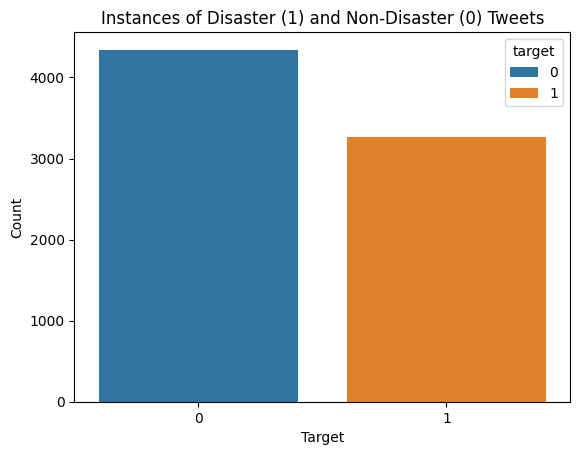

In [63]:
sns.countplot(data=train_df, x='target', hue='target')
plt.title('Instances of Disaster (1) and Non-Disaster (0) Tweets')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

There is an imbalance in the training dataset. Specifically, there are more negative instances than positive instances.

Before entering the data into the model, some cleaning tasks (see below) were completed.
- convert text to lowercase
- remove URLs from text
- remove symbols used for mentions and hashtags
- remove stopwords (e.g., "the", "a")
- lemmatize text (i.e., reducing a word to its root form)

In [64]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user mentions and hashtags
    text = re.sub(r'\@\w+|\#', '', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [w for w in tokens if not w in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [65]:
# Process text of input variables
train_df["processed_text"] = train_df["text"].apply(preprocess_text)
test_df["processed_text"] = test_df["text"].apply(preprocess_text)

train_df["processed_keyword"] = train_df["keyword"].apply(preprocess_text)
test_df["processed_keyword"] = test_df["keyword"].apply(preprocess_text)

train_df["processed_location"] = train_df["location"].apply(preprocess_text)
test_df["processed_location"] = test_df["location"].apply(preprocess_text)

# Count the number of words per tweet
train_df["word_count"] = train_df["processed_text"].str.split().str.len()
test_df["word_count"] = test_df["processed_text"].str.split().str.len()

# Combined text to create tokens
train_df["combined_text"] = train_df["processed_text"] + " " + train_df["processed_keyword"]
test_df["combined_text"] = test_df["processed_text"] + " " + test_df["processed_keyword"]

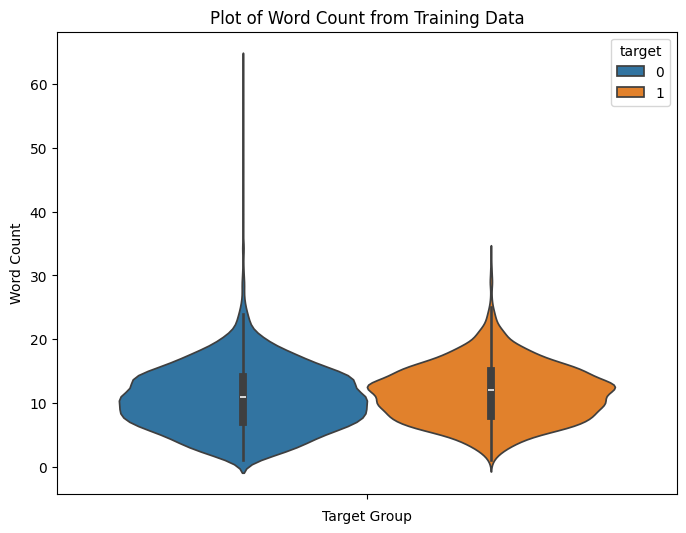

In [66]:
plt.figure(figsize=(8, 6))

sns.violinplot(data=train_df, y='word_count', hue='target')
plt.xlabel('Target Group')
plt.ylabel('Word Count')
plt.title('Plot of Word Count from Training Data')
plt.show()

Based on the violin plots, tweets from the diaster and non-disaster groups appeared to have similar medians and distributions. However, there appeared to be more outliers in the non-disaster group. To provide more information, descriptive statistics of both groups were be examined and a hypothesis test was conducted to see if the groups were significantly different from each other.

In [67]:
# Calculate and print descriptive statistics for each target group
grouped_stats = train_df.groupby('target')['word_count'].describe()
print('Statistics for Target Groups')
print(grouped_stats)

Statistics for Target Groups
         count       mean       std  min  25%   50%   75%   max
target                                                         
0       4342.0  10.831184  5.181819  1.0  7.0  11.0  14.0  63.0
1       3271.0  11.578111  4.393691  1.0  8.0  12.0  15.0  33.0


In [68]:
from scipy.stats import shapiro

alpha = 0.05

neg_instances_word_count = train_df[train_df['target']==0]['word_count']
pos_instances_word_count = train_df[train_df['target']==1]['word_count']

# Check if distribution of word count in training set is Gaussian
neg_stat, neg_p_value = shapiro(neg_instances_word_count)
pos_stat, pos_p_value = shapiro(pos_instances_word_count)

# Interpret p-values
if neg_p_value < alpha:
    print("The negative instances are signficantly different from a normal distribution")
else:
    print("The negative instances are signficantly different from a normal distribution")

if pos_p_value < alpha:
    print("The positive instances are signficantly different from a normal distribution")
else:
    print("The positive instances are signficantly different from a normal distribution")


The negative instances are signficantly different from a normal distribution
The positive instances are signficantly different from a normal distribution


The results of the Shapiro-Wilk test indicates that the word counts for the negative and positive instances are not normal. Therefore, the Mann Whitney U hypothesis test will be used to determine if there is a statistically significant difference between the groups.

In [69]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(neg_instances_word_count, pos_instances_word_count)

if p_value < alpha:
    print('There is a statistically significant difference between the groups.')
else:
    print('There is not a statistically significant difference between the groups')

There is a statistically significant difference between the groups.


The results of the Man-Whitney U test indicate there is a statistically significant difference between the two groups. Based on this information, the word count per post was included as a feature in the model.

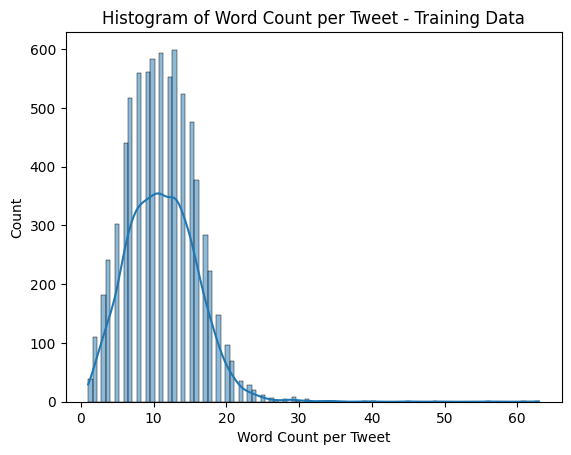

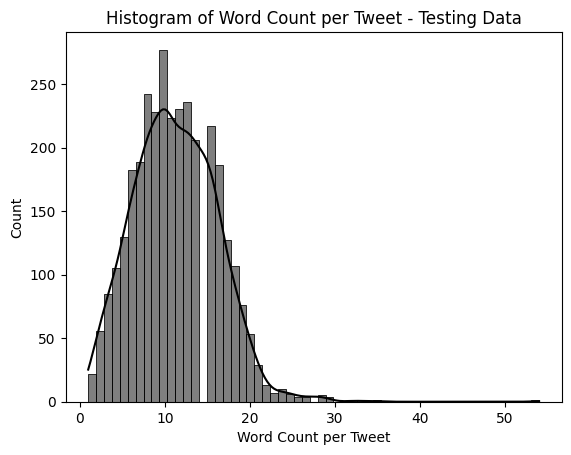

In [70]:
# Create histogram of word count in training dataset

sns.histplot(data=train_df, x="word_count", kde=True)
plt.xlabel("Word Count per Tweet")
plt.title("Histogram of Word Count per Tweet - Training Data")
plt.show()

# Create histogram of word count in testing dataset

sns.histplot(data=test_df, x="word_count", kde=True, color="black")
plt.xlabel("Word Count per Tweet")
plt.title("Histogram of Word Count per Tweet - Testing Data")
plt.show()

In [71]:
from scipy.stats import mannwhitneyu

# Use Whitney-Mann U test since the data are not normally distributed
u_stat, u_pvalue = mannwhitneyu(train_df['word_count'], test_df['word_count'])

# Interpret p-value
if u_pvalue > alpha:
    print("There is no statistically significant difference between the groups")
else:
    print("There is a statistically significant difference beween the groups")


There is no statistically significant difference between the groups


In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Normalize word count
scaler = StandardScaler()
word_count_train = scaler.fit_transform(train_df["word_count"].values.reshape(-1,1))
word_count_test = scaler.fit_transform(test_df["word_count"].values.reshape(-1,1))

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df["combined_text"])

# Vocabulary size (adding 1 for padding token)
vocabulary_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocabulary_size}")

# Convert texts to sequences
sequences_train = tokenizer.texts_to_sequences(train_df["combined_text"])
sequences_test = tokenizer.texts_to_sequences(test_df["combined_text"])

# Find max sequence length in the training set for padding
max_length = max(max(len(sequence) for sequence in sequences_train),
                 max(len(sequence) for sequence in sequences_test))

print(f"Max Length of Sequences: {max_length}")

# Pad sequences
X_train = pad_sequences(sequences_train, maxlen=max_length)
X_test = pad_sequences(sequences_test, maxlen=max_length)

y_train = train_df["target"].values

Vocabulary Size: 14210
Max Length of Sequences: 27


# Model Development

In [73]:
from tensorflow.keras.layers import Concatenate, Input, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

l2_factor = 0.01

# Define two inputs: one for the text sequences and one for the word count
sequence_input = Input(shape=(max_length,), dtype='int32')
word_count_input = Input(shape=(1,), dtype='float32')

# Text embeddings
text_embedded = Embedding(input_dim=vocabulary_size, output_dim=50)(sequence_input)
text_pooled = GlobalAveragePooling1D()(text_embedded)

# Concatenate text features with the word count
concatenated = Concatenate()([text_pooled, word_count_input])

# Dense layers
dense1 = Dense(300, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_factor))(concatenated)
dense2 = Dense(100, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_factor))(dense1)
output_layer = Dense(1, activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_factor))(dense2)

# Create the model with two inputs
model = Model(inputs=[sequence_input, word_count_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary to check the architecture
model.summary()


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 27)]                 0         []                            
                                                                                                  
 embedding_13 (Embedding)    (None, 27, 50)               710500    ['input_27[0][0]']            
                                                                                                  
 global_average_pooling1d_1  (None, 50)                   0         ['embedding_13[0][0]']        
  (GlobalAveragePooling1D)                                                                        
                                                                                                  
 input_28 (InputLayer)       [(None, 1)]                  0         []                     

In [74]:
history = model.fit(
    [X_train, word_count_train], y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

Epoch 1/20
191/191 [==============================] - 5s 21ms/step - loss: 4.2100 - accuracy: 0.5770 - val_loss: 1.9111 - val_accuracy: 0.5345
Epoch 2/20
191/191 [==============================] - 5s 26ms/step - loss: 1.2525 - accuracy: 0.5839 - val_loss: 0.8939 - val_accuracy: 0.5719
Epoch 3/20
191/191 [==============================] - 3s 16ms/step - loss: 0.7032 - accuracy: 0.7608 - val_loss: 0.6408 - val_accuracy: 0.7945
Epoch 4/20
191/191 [==============================] - 3s 17ms/step - loss: 0.5185 - accuracy: 0.8581 - val_loss: 0.5961 - val_accuracy: 0.8011
Epoch 5/20
191/191 [==============================] - 4s 19ms/step - loss: 0.4674 - accuracy: 0.8795 - val_loss: 0.5956 - val_accuracy: 0.7965
Epoch 6/20
191/191 [==============================] - 4s 20ms/step - loss: 0.4416 - accuracy: 0.8903 - val_loss: 0.5998 - val_accuracy: 0.7958
Epoch 7/20
191/191 [==============================] - 3s 16ms/step - loss: 0.4173 - accuracy: 0.9059 - val_loss: 0.6003 - val_accuracy: 0.7905

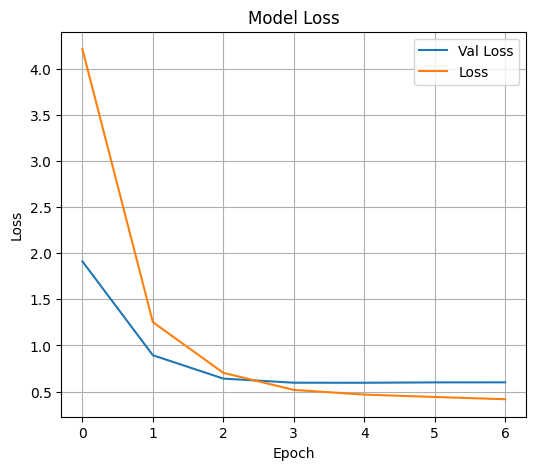

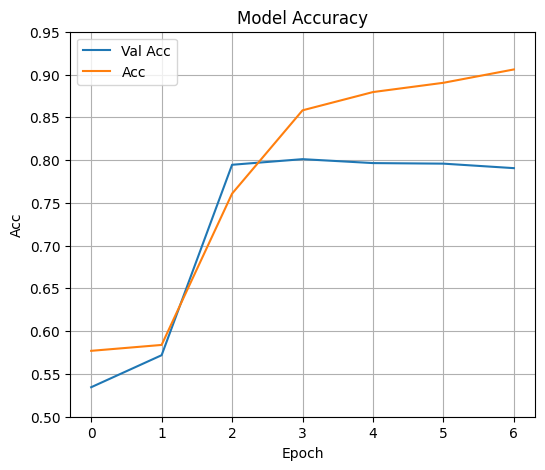

In [75]:
val_loss = history.history['val_loss']
loss = history.history['loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(6,5))

plt.plot(val_loss, label='Val Loss')
plt.plot(loss, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))

plt.plot(val_acc, label='Val Acc')
plt.plot(acc, label='Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Model Accuracy')
plt.ylim(0.5, .95)
plt.legend()
plt.grid(True)
plt.show()

In [76]:
predictions = model.predict([X_test, word_count_test])
target = (predictions > 0.5).astype(int)
target = target.flatten()

id = test_df['id']

submission_df = pd.DataFrame(zip(id, target), columns=['id', 'target'])

submission_df.to_csv('/content/drive/MyDrive/IntroDeepLearning/final_entry.csv', index=False)

102/102 [==============================] - 1s 7ms/step


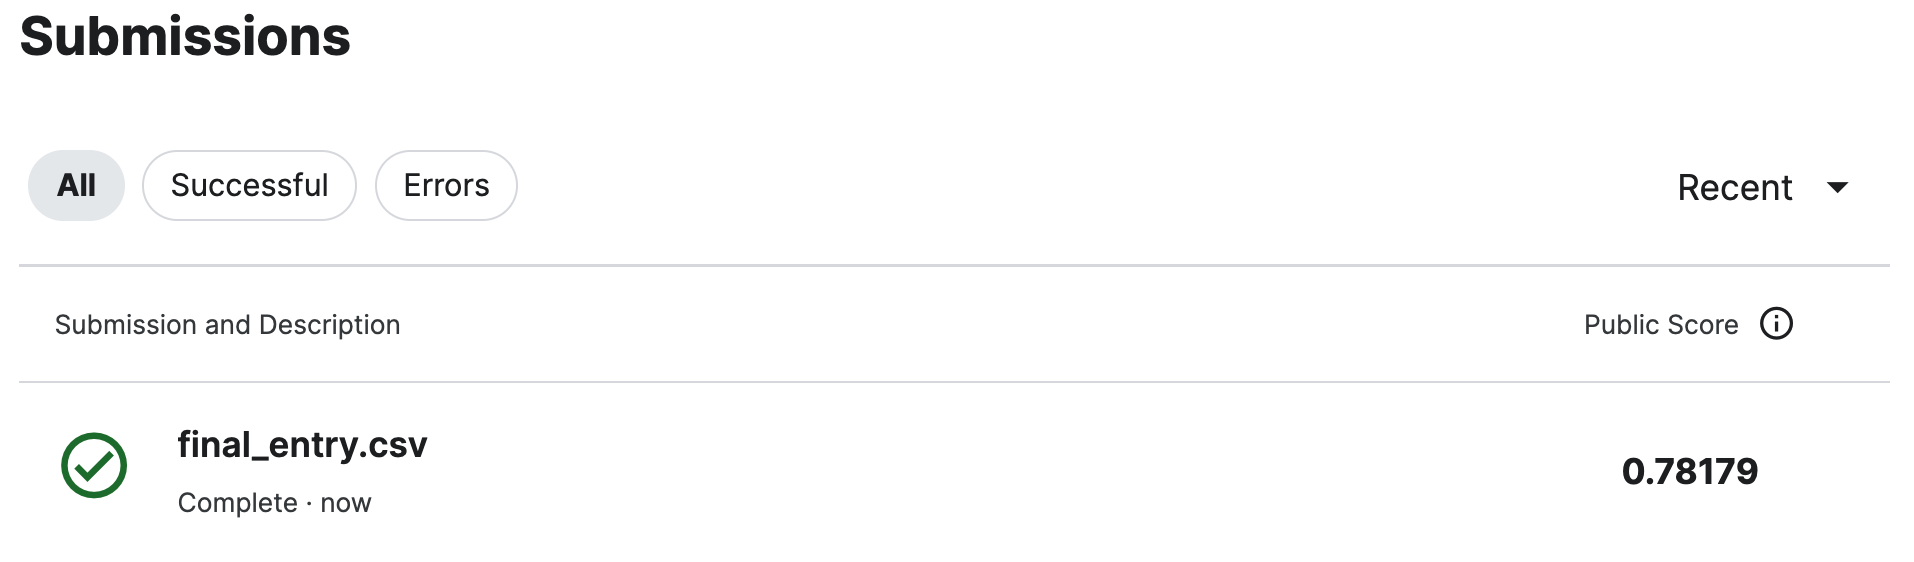

# Performance on Test Data

To determine the performance on the test data, predictions made by the model were submitted to a Kaggle competition. The F1 score of the model was 0.78179, which indicates the model performed moderately well. To determine if a different architecture could improve the model's performance, a Bidirectional Long Short Term Layer (LTSM) was added to the model.

In [77]:
from tensorflow.keras.layers import Concatenate, Input, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

l2_factor = 0.0001

# Define two inputs: one for the text sequences and one for the word count
sequence_input = Input(shape=(max_length,), dtype='int32')
word_count_input = Input(shape=(1,), dtype='float32')

# Text embeddings
text_embedded = Embedding(input_dim=vocabulary_size, output_dim=50)(sequence_input)

# Bidirectional LSTM
bi_lstm = Bidirectional(LSTM(64, return_sequences=False))(text_embedded)

# Concatenate LSTM output with the word count
concatenated = Concatenate()([bi_lstm, word_count_input])

# Dense layers
dense1 = Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_factor))(concatenated)
dense2 = Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_factor))(dense1)
output_layer = Dense(1, activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_factor))(dense2)

# Create the model with two inputs
model = Model(inputs=[sequence_input, word_count_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary to check the architecture
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 27)]                 0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 27, 50)               710500    ['input_29[0][0]']            
                                                                                                  
 bidirectional_12 (Bidirect  (None, 128)                  58880     ['embedding_14[0][0]']        
 ional)                                                                                           
                                                                                                  
 input_30 (InputLayer)       [(None, 1)]                  0         []                     

In [78]:
history = model.fit(
    [X_train, word_count_train], y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

Epoch 1/20
191/191 [==============================] - 18s 65ms/step - loss: 0.5895 - accuracy: 0.7235 - val_loss: 0.5079 - val_accuracy: 0.7807
Epoch 2/20
191/191 [==============================] - 14s 74ms/step - loss: 0.3511 - accuracy: 0.8731 - val_loss: 0.5516 - val_accuracy: 0.7610
Epoch 3/20
191/191 [==============================] - 13s 66ms/step - loss: 0.2408 - accuracy: 0.9213 - val_loss: 0.5973 - val_accuracy: 0.7446


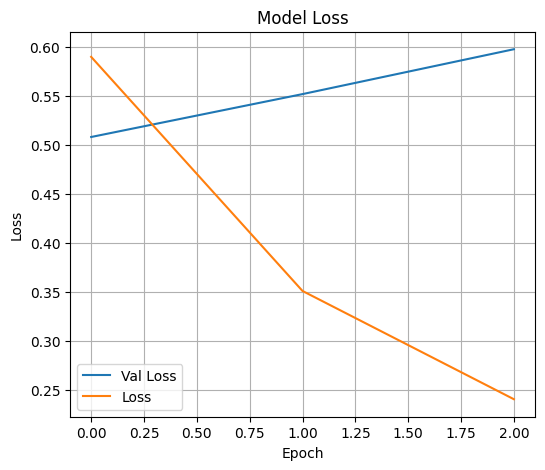

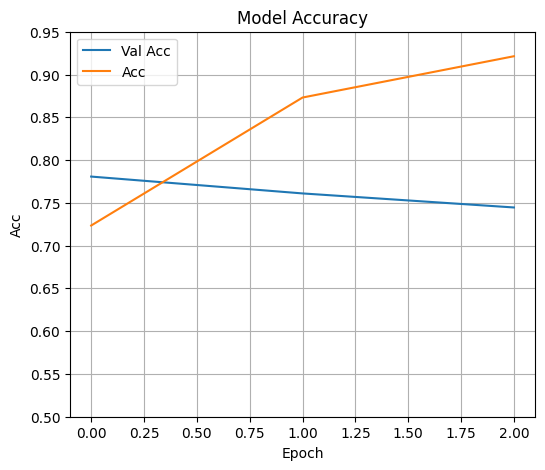

In [79]:
val_loss = history.history['val_loss']
loss = history.history['loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(6,5))

plt.plot(val_loss, label='Val Loss')
plt.plot(loss, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))

plt.plot(val_acc, label='Val Acc')
plt.plot(acc, label='Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Model Accuracy')
plt.ylim(0.5, .95)
plt.legend()
plt.grid(True)
plt.show()

The top plot shows the loss for the training and validation sets. The training set loss decreases across epochs, indicating that the model was learning over time. The validation set loss is increasing over time, indicating the model was overfitting the training set and would not generalize well to unseen data.

The bottom plot shows the accuracy of the model on the training and validation sets. The training set increases across epochs, indicating that the model was learning over time. The validation set decreases slightly over time, which is consistent with overfitting.

These trends emerged over a few epochs, which could indicate that the model was too complex for the task. To explore this theory, a simpler Bidirectional LSTM model was created.

In [80]:
predictions = model.predict([X_test, word_count_test])
target = (predictions > 0.5).astype(int)
target = target.flatten()

id = test_df['id']

submission_df = pd.DataFrame(zip(id, target), columns=['id', 'target'])

submission_df.to_csv('/content/drive/MyDrive/IntroDeepLearning/bidirectional_entry.csv', index=False)

102/102 [==============================] - 2s 10ms/step


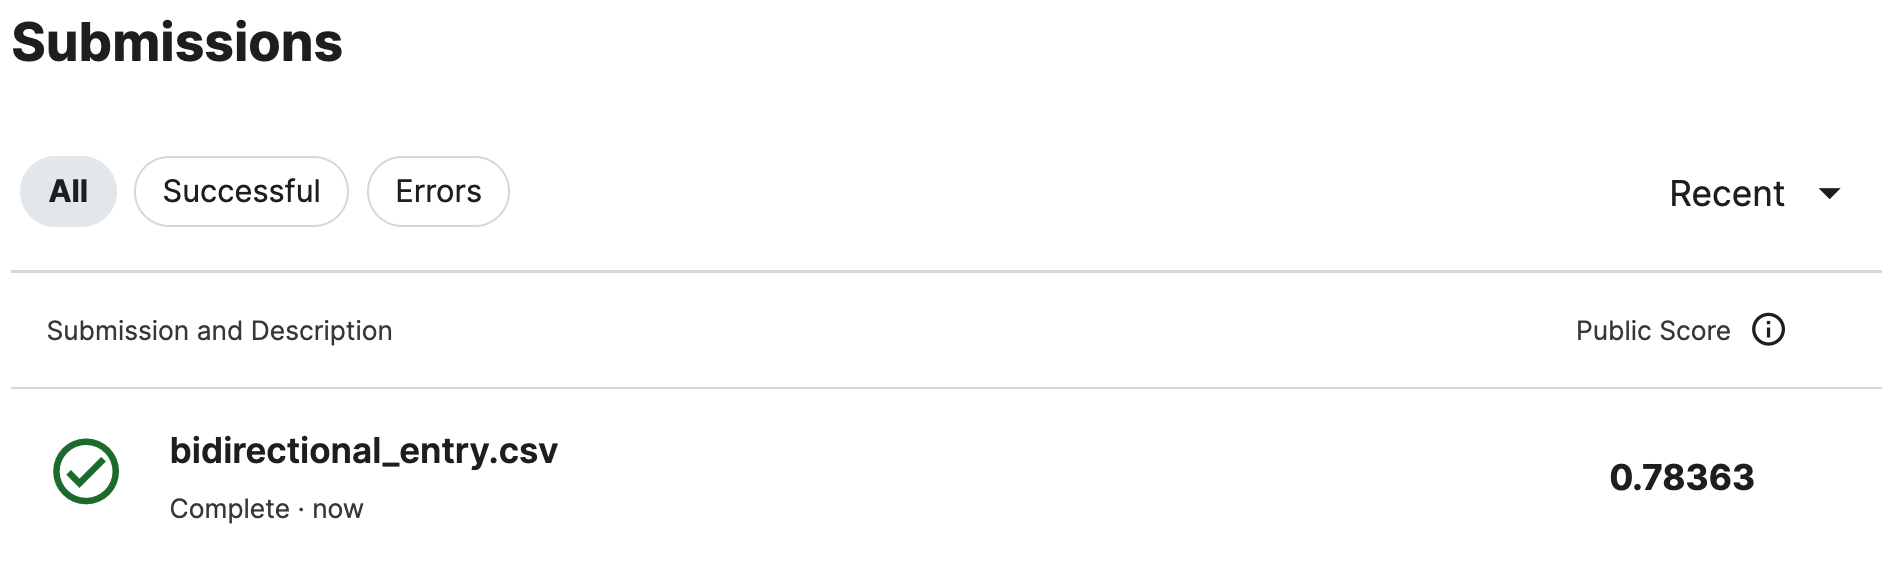

The F1 score of the Bidirectional LSTM model was 0.78363, which is slightly above the score obtained by the simple ANN.

In [81]:
l2_factor = 0.0001

# Define two inputs: one for the text sequences and one for the word count
sequence_input = Input(shape=(max_length,), dtype='int32')
word_count_input = Input(shape=(1,), dtype='float32')

# Text embeddings
text_embedded = Embedding(input_dim=vocabulary_size, output_dim=50)(sequence_input)

# Bidirectional LSTM
bi_lstm = Bidirectional(LSTM(3, return_sequences=False))(text_embedded)

# Concatenate LSTM output with the word count
concatenated = Concatenate()([bi_lstm, word_count_input])

# Dense layers
dense1 = Dense(2, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_factor))(concatenated)
output_layer = Dense(1, activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_factor))(dense1)

# Create the model with two inputs
model = Model(inputs=[sequence_input, word_count_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary to check the architecture
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 27)]                 0         []                            
                                                                                                  
 embedding_15 (Embedding)    (None, 27, 50)               710500    ['input_31[0][0]']            
                                                                                                  
 bidirectional_13 (Bidirect  (None, 6)                    1296      ['embedding_15[0][0]']        
 ional)                                                                                           
                                                                                                  
 input_32 (InputLayer)       [(None, 1)]                  0         []                     

In [82]:
history = model.fit(
    [X_train, word_count_train], y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

Epoch 1/20
191/191 [==============================] - 16s 61ms/step - loss: 0.6562 - accuracy: 0.5591 - val_loss: 0.6242 - val_accuracy: 0.5345
Epoch 2/20
191/191 [==============================] - 9s 46ms/step - loss: 0.4937 - accuracy: 0.7788 - val_loss: 0.5391 - val_accuracy: 0.7426
Epoch 3/20
191/191 [==============================] - 6s 34ms/step - loss: 0.3258 - accuracy: 0.8951 - val_loss: 0.5251 - val_accuracy: 0.7525
Epoch 4/20
191/191 [==============================] - 8s 43ms/step - loss: 0.2372 - accuracy: 0.9261 - val_loss: 0.6201 - val_accuracy: 0.7177
Epoch 5/20
191/191 [==============================] - 6s 33ms/step - loss: 0.1826 - accuracy: 0.9461 - val_loss: 0.6679 - val_accuracy: 0.7183


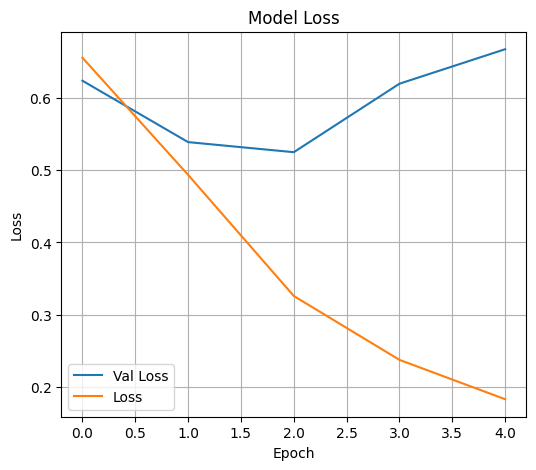

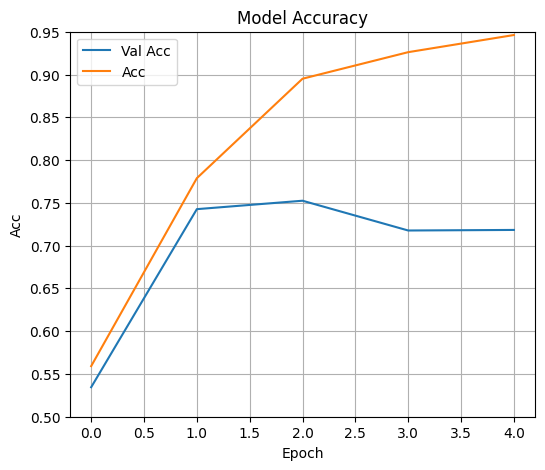

In [83]:
val_loss = history.history['val_loss']
loss = history.history['loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(6,5))

plt.plot(val_loss, label='Val Loss')
plt.plot(loss, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))

plt.plot(val_acc, label='Val Acc')
plt.plot(acc, label='Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Model Accuracy')
plt.ylim(0.5, .95)
plt.legend()
plt.grid(True)
plt.show()

Despite using a very simplified version of a Bidirectional LSTM model, both plots indicate signs of overfitting on the validation set.  

In [84]:
predictions = model.predict([X_test, word_count_test])
target = (predictions > 0.5).astype(int)
target = target.flatten()

id = test_df['id']

submission_df = pd.DataFrame(zip(id, target), columns=['id', 'target'])

submission_df.to_csv('/content/drive/MyDrive/IntroDeepLearning/simple_bidirectional_entry.csv', index=False)

102/102 [==============================] - 2s 6ms/step


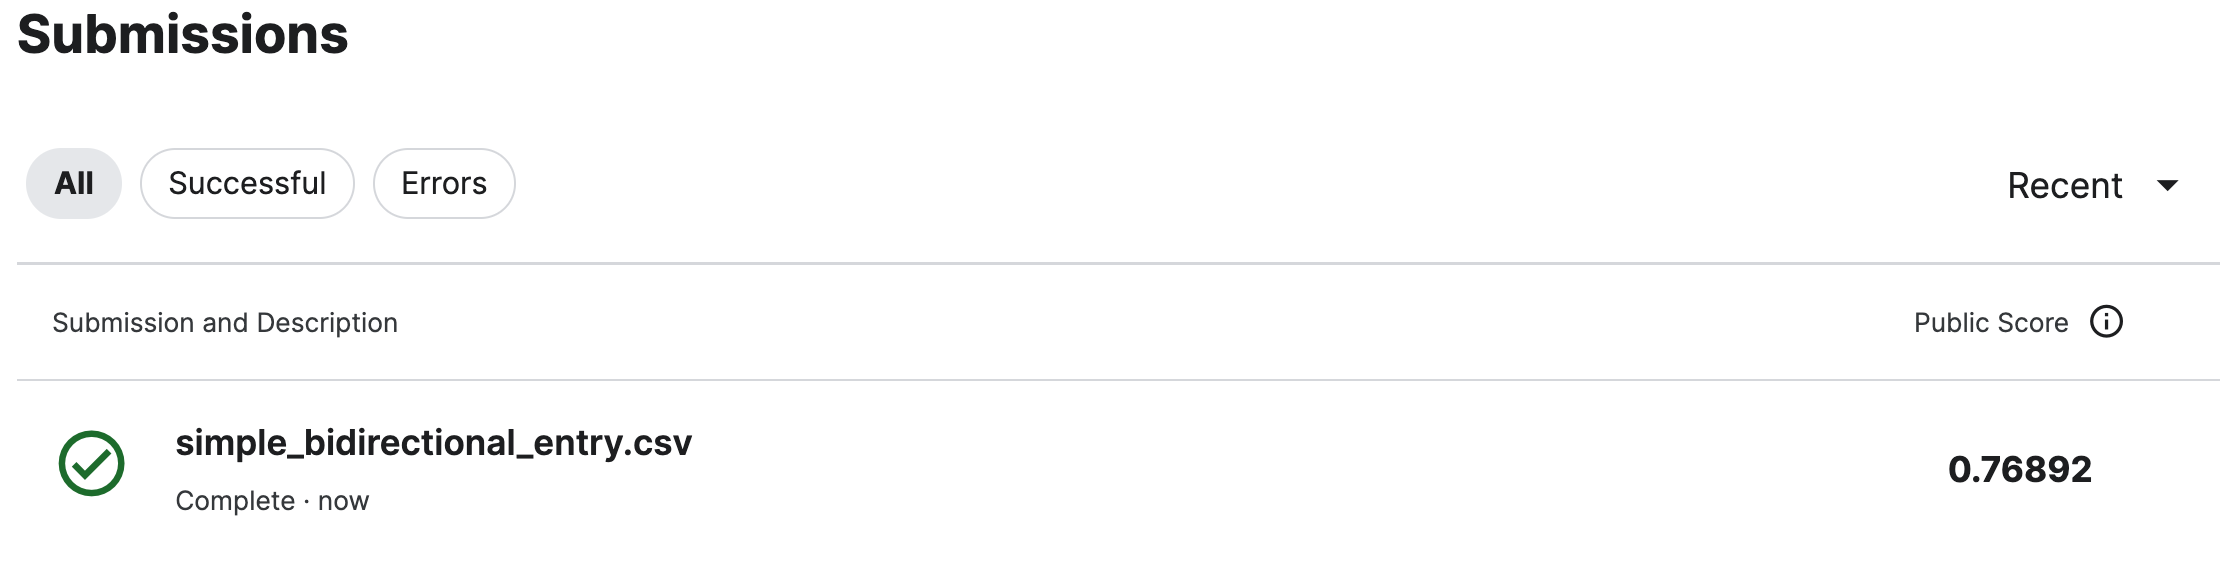

The F1 score of the simple Bidirectional LSTM model was the lowest of the three models.

# Model Comparison

 The Bidirectional LSTM model performed the best on the test data; however, its performance was only slightly better the simple ANN.

 According to the literature, there are multiple explanations for why a Bidirectional LSTM model would perform better than a simple ANN, including:

 - Differences in how the model's understand context: Bidirectional recurrent neural networks (RNNs) read data left-to-right and right-to-left, which helps them better understand the context of text. Simple ANNs do not read data in both directions, which limits their ability to consider the words before and after a specific word.

 - Improved Learning of Dependencies: Architectures of RNNs, like LSTM, are better equipped to handle long-range dependencies compared to simple ANNs. The ability to handle long-range dependencies makes it more likely that the model will identify long-distance relations that might be missed by a simple ANN.

 - Enhanced Feature Extraction: The Bidirectional LSTM's ability to process data in both directions often results in the ability to extract more and better information from inputted texts.

Although there were multiple potential explanations as to why the Bidirectional LSTM performed better than the simple ANN, it is important to note that the actual difference in their performance was minimal. One potential reason for their simlar performance could be the minimal optimization of the hyperparameters due to time limitations. Another potential reason could be related to the imbalance of positive and negative instances in the training data. Potentially, the Bidirectional LSTM was better suited to handle the imbalance. At this time, it is unclear as to why the simple Bidirectional LSTM model performed the worst on the test set.

In future iterations of this project, additional time will be allocated for hyperparameter tuning and addressing the imbalanced training data.

# References

"Deep Learning" by Ian Goodfellow, Yoshua Bengio, and Aaron Courville:
http://www.deeplearningbook.org/

"Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow by Aurelien Geron: https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/

Keras Documentation: https://keras.io/

TensorFlow Documentation: https://www.tensorflow.org/

Understanding LSTM Networks by Christopher Olah: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

